# Introduction
### Goals of project:
Natural Language Inference (NLI) is a pivotal task in natural language understanding, aiming to ascertain if a statement logically follows from a given premise.

For instance, given the premise: "He returned to the clinic three weeks later and was prescribed antibiotics" an NLI system should deduce that the statement "The patient has an infection" is entailed by the premise.

In recent years, there has been a significant surge in the publication of Clinical Trial Reports (CTRs). As a result, it has become increasingly challenging for clinical practitioners to keep pace with the ever-growing literature to offer personalized evidence-based care. In this context, NLI presents an opportunity to aid in the large-scale interpretation and retrieval of medical evidence.

In this project, we propose to tackle a textual entailment task using clinical trial data. The task is based on a dataset comprising breast cancer CTRs, statements, and labels annotated by domain expert annotators. The annotated statements represent sentences that make a claim about the information within one of the sections in the CTR. The objective is to determine the inference relation (entailment vs. contradiction) between CTR-statement pairs. Additionally, we encourage the exploration of evidence-based retrieval, wherein the NLI system extracts a set of supporting facts from the premise to justify its predictions.

### Dataset : 
Dataset (https://sites.google.com/view/nli4ct/semeval-2024/get-data-and-starting-kit)
The statements and evidence are generated by clinical domain experts, clinical trial organisers, and research oncologists from the Cancer Research UK Manchester Institute and the Digital Experimental Cancer Medicine Team.

Description
Each Clinical Trial Report (CTR) consists of 4 sections:

Eligibility criteria - A set of conditions for patients to be allowed to take part in the clinical trial

Intervention - Information concerning the type, dosage, frequency, and duration of treatments being studied.

Results - Number of participants in the trial, outcome measures, units, and the results.

Adverse events - These are signs and symptoms observed in patients during the clinical trial.

For this task, each CTR may contain 1-2 patient groups, called cohorts or arms. These groups may receive different treatments, or have different baseline characteristics. Below is an example CTR from our dataset (see NCT02429427 for the original report).

In [31]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import f1_score,precision_score,recall_score

In [3]:
# Dev set
import json

dev_path = "training_data/dev.json"
# dev_path = "test.json"
with open(dev_path) as json_file:
    dev = json.load(json_file)

# Example instance
print(dev[list(dev.keys())[1]])

{'Type': 'Comparison', 'Section_id': 'Eligibility', 'Primary_id': 'NCT00425854', 'Secondary_id': 'NCT01224678', 'Statement': 'Patients with significantly elevated ejection fraction are excluded from the primary trial, but can still be eligible for the secondary trial if they are 55 years of age or over', 'Label': 'Contradiction'}


In [3]:
uuid_list = list(dev.keys())
statements = []
gold_dev_primary_evidence = []
gold_dev_secondary_evidence = []
for i in range(len(uuid_list)):
  #Retrieve all statements from the development set
  statements.append(dev[uuid_list[i]]["Statement"])

## Basline
we can try TF-IDF as a proper baseline for our task.
TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects the importance of a word in a document relative to a collection of documents. It's commonly used in information retrieval and text mining to determine the significance of a term within a document corpus.
TF-IDF Formula:

$
\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)
$

Where:
- $\text{TF}(t, d)$ is the term frequency of term $t$ in document $d$, representing how often a term appears within a specific document.
- $\text{IDF}(t, D)$ is the inverse document frequency of term $t$ across the entire document corpus $D$, indicating how unique or rare a term is across all documents in the corpus.

The formula multiplies the term frequency (how often a term appears in a document) by the inverse document frequency (how unique the term is across the entire document corpus) to compute the TF-IDF score for a given term in a specific document.


In [4]:
Results = {}

for i in range(len(uuid_list)):
  primary_ctr_path = os.path.join("training_data/CT json",dev[uuid_list[i]]["Primary_id"]+".json")
  with open(primary_ctr_path) as json_file:
    primary_ctr = json.load(json_file)

  #Retrieve the full section from the primary trial
  primary_section = primary_ctr[dev[uuid_list[i]]["Section_id"]]

  #Convert a primary section entries to a matrix of TF-IDF features.
  vectorizer = TfidfVectorizer().fit(primary_section)
  X_s = vectorizer.transform([statements[i]])
  X_p = vectorizer.transform(primary_section)

  #Compute the cosine similarity between the primary section entries and the statement
  primary_scores = cosine_distances(X_s, X_p)
  #Repeat for the secondary trial
  if dev[uuid_list[i]]["Type"] == "Comparison":
    secondary_ctr_path = os.path.join("training_data/CT json",dev[uuid_list[i]]["Secondary_id"]+".json")
    with open(secondary_ctr_path) as json_file:
      secondary_ctr = json.load(json_file)
    secondary_section = secondary_ctr[dev[uuid_list[i]]["Section_id"]]
    vectorizer = TfidfVectorizer().fit(secondary_section)
    X_s = vectorizer.transform([statements[i]])
    X_p = vectorizer.transform(secondary_section)
    secondary_scores = cosine_distances(X_s, X_p)
    #Combine and average the cosine distances of all entries from the relevant section of the primary and secondary trial
    combined_scores = []
    combined_scores.extend(secondary_scores[0])
    combined_scores.extend(primary_scores[0])
    score = numpy.average(combined_scores)
    #If the cosine distance is gless than 0.9 the prediction is entailment
    if score > 0.9:
      Prediction = "Contradiction"
    else:
      Prediction = "Entailment"
    Results[str(uuid_list[i])] = {"Prediction":Prediction}
  else:
    #If the cosine distance is greater than 0.9 the prediction is contradiction
    score = numpy.average(primary_scores)
    if score > 0.95:
      Prediction = "Contradiction"
    else:
      Prediction = "Entailment"
    Results[str(uuid_list[i])] = {"Prediction":Prediction}


In [5]:
with open("results.json",'w') as jsonFile:
    jsonFile.write(json.dumps(Results,indent=4))

## Evaluation

Compute F1 score, Precision, and Recall. Note that in the final evaluation systems will be ranked by Faithfulness and Consistency, which cannot be computed on the training and development set.

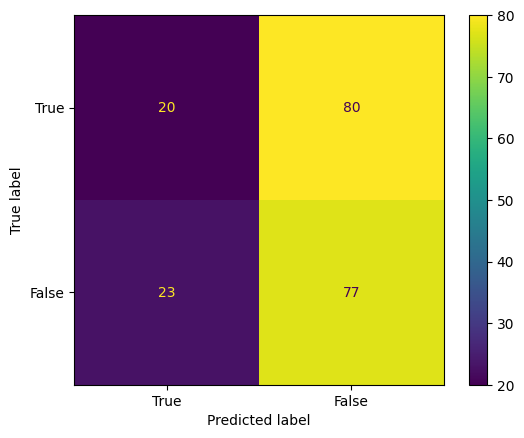

F1:0.599222
precision_score:0.490446
recall_score:0.770000


In [6]:
def main():

    gold = dev
    results = Results
    uuid_list = list(results.keys())

    results_pred = []
    gold_labels = []
    for i in range(len(uuid_list)):
        if results[uuid_list[i]]["Prediction"] == "Entailment":
            results_pred.append(1)
        else:
            results_pred.append(0)
        if gold[uuid_list[i]]["Label"] == "Entailment":
            gold_labels.append(1)
        else:
            gold_labels.append(0)

    f_score = f1_score(gold_labels,results_pred)
    p_score = precision_score(gold_labels,results_pred)
    r_score = recall_score(gold_labels,results_pred)


    confusion_matrix = metrics.confusion_matrix(gold_labels, results_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

    cm_display.plot()
    plt.show()

    
    print('F1:{:f}'.format(f_score))
    print('precision_score:{:f}'.format(p_score))
    print('recall_score:{:f}'.format(r_score))

if '__main__' == __name__:
    main()

As we can notice the performance is not desirable with a simple TF-IDF alogirthm

# Methodology 
## Utilizing BERT Embeddings for Text Classification
### Introduction
In this documentation, we explore the process of leveraging BERT (Bidirectional Encoder Representations from Transformers) embeddings for text classification tasks. The objective is to utilize the powerful contextual embeddings provided by BERT to enhance the performance of text classification models.

## Stage 1: BERT Embeddings Extraction
## Overview
BERT, a transformer-based architecture, is utilized to generate embeddings for textual inputs.
The pre-trained BERT model is employed to encode input text sequences into fixed-dimensional embeddings.
Implementation
BERT Model Selection: Choose a pre-trained BERT model suitable for the task (e.g., BERT-base, BERT-large).
Tokenization: Convert input text into tokenized format compatible with BERT tokenizer.
Embeddings Extraction: Utilize the BERT model to obtain contextual embeddings for each tokenized input sequence.

## Stage 2: Cosine Similarity Analysis
### Overview
Evaluate the effectiveness of BERT embeddings using cosine similarity.
Cosine similarity measures the similarity between two vectors by calculating the cosine of the angle between them.
Implementation
Similarity Calculation: Compute cosine similarity between pairs of BERT embeddings.
Thresholding: Set a threshold value to classify similarity scores into relevant categories (e.g., similar, dissimilar).
Evaluation Metrics: Measure the performance of cosine similarity analysis using relevant evaluation metrics (e.g., accuracy, precision, recall).

## Stage 3: Neural Network Model Training
### Overview
Develop a neural network model for text classification using BERT embeddings as input features.
Train the model on labeled data to learn the relationship between input embeddings and corresponding class labels.
Implementation
Model Architecture: Design a neural network architecture suitable for the classification task (e.g., CNN, LSTM, Transformer).
Data Preprocessing: Prepare the labeled dataset by encoding class labels and organizing input embeddings.
Model Training: Train the neural network model using the prepared dataset and appropriate training techniques (e.g., batch training, optimization algorithms).
Evaluation: Assess the performance of the trained model using standard evaluation metrics (e.g., accuracy, F1-score) on a separate validation or test datas

In [4]:
from models import get_encoded_output, get_encoded_output_

### Testing the get_enocded_output function

In [8]:
input_text = "The movie was not good"
# Get encoded representations for each word
word_embeddings = get_encoded_output(input_text, output_type="word")
print("Word Embeddings:")
print(word_embeddings)

# Get a single encoded representation for the entire sentence
sentence_embedding = get_encoded_output(input_text, output_type="sentence")
print("Sentence Embedding:")
print(sentence_embedding)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Robin_T480\Desktop\UNIMI\Second Semester\Text mining UNIMI\PROJECT\tm_project\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Robin_T480\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Word Embeddings:
tensor([[[-0.0045, -0.0669,  0.2431,  ..., -0.1254,  0.4185,  0.2122],
         [-0.0925, -0.6807, -0.2746,  ..., -0.3027,  0.9930, -0.2668],
         [ 0.4596, -0.4590,  0.0378,  ..., -0.1457,  0.2256, -0.3880],
         ...,
         [-0.1697, -0.7657, -0.0144,  ..., -0.5234,  0.1603, -0.2652],
         [-0.1901, -0.4958, -0.1519,  ..., -0.1929,  0.2817, -0.7677],
         [ 0.9104,  0.2334, -0.2340,  ...,  0.0887, -0.2596, -0.3921]]])


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Sentence Embedding:
tensor([[-4.4745e-03, -6.6949e-02,  2.4315e-01,  6.7506e-02, -6.9714e-02,
         -1.0044e-01,  1.9356e-01,  3.4729e-01, -4.2048e-02, -7.8176e-02,
          5.3189e-02, -2.6494e-02,  9.3023e-02,  3.7194e-01,  6.5695e-02,
          1.8146e-01,  1.0495e-02,  1.0758e-01,  1.6325e-01, -1.5964e-01,
         -3.8459e-01, -2.2864e-01,  5.4895e-02,  7.3743e-02, -1.9447e-01,
         -6.1785e-02, -1.0123e-02, -3.0036e-02,  2.7452e-02, -2.4594e-02,
         -4.2041e-02,  4.0464e-02, -2.4051e-01, -1.4729e-02, -8.8758e-03,
          1.7646e-02,  9.5002e-02,  4.0724e-02,  1.8393e-02, -7.0678e-02,
         -3.4517e-03,  4.7216e-02,  1.8671e-01,  1.3307e-02, -4.1325e-02,
         -1.4024e-04, -2.0831e+00, -6.2376e-02, -8.8633e-03, -2.9843e-01,
          4.0579e-01,  6.4623e-02,  1.3973e-01,  3.0985e-01,  2.5628e-01,
          2.3686e-01, -1.2070e-01,  3.9054e-01, -1.8148e-01,  1.3308e-01,
          2.1843e-01, -1.4245e-01, -8.3689e-02, -2.1181e-02, -6.9664e-02,
          3.9123e-

## Addressing Input Length Limitations in BERT-based Text Classification

### Introduction:
In this documentation, we address the challenge of input length limitations encountered when utilizing BERT models for text classification tasks. We explore various methods to overcome this constraint, focusing on the application of text and input chunking techniques. Our objective is to effectively process longer text inputs while maintaining the accuracy and performance of BERT-based classification models.

### Problem Statement:
The limitations imposed by BERT models on input sequence length pose a significant challenge, especially when dealing with longer textual inputs. These limitations hinder the effective utilization of BERT embeddings for tasks such as text classification, where comprehensive understanding of input texts is essential.

### Proposed Solution:
To mitigate the impact of input length restrictions, we employ text and input chunking methods. This approach involves breaking down longer text inputs into smaller chunks that fit within the maximum input length supported by BERT models. By segmenting the input text, we ensure that all relevant information is captured and processed effectively.

### Implementation:

Text and Input Chunking:
Utilize text and input chunking techniques to divide longer text inputs into manageable segments.
Segment the input text based on predefined chunk sizes, ensuring that each segment conforms to the input length limitations of BERT models.
Aggregation Strategy:
Apply a simple averaging approach to aggregate the embedded chunks of each sample.
Compute the average embedding vector for each chunk and combine them to represent the entire input sequence.

### Benefits:

Enables the processing of longer text inputs that exceed the input length limitations of BERT models.
Preserves the contextual information and semantic meaning of input texts by effectively capturing all relevant segments.
Facilitates the utilization of BERT embeddings for text classification tasks, even with extensive textual inputs.
### Conclusion:
By adopting text and input chunking methods, we effectively address the challenges posed by input length limitations in BERT-based text classification. Our approach ensures that all pertinent information within longer text inputs is captured and processed accurately, enhancing the applicability and utility of BERT models for real-world classification tasks.

In [9]:
from utils import chunk_text

In [10]:
import torch

for i in range(len(uuid_list)):
    primary_ctr_path = os.path.join("training_data/CT json", dev[uuid_list[i]]["Primary_id"] + ".json")
    with open(primary_ctr_path) as json_file:
        primary_ctr = json.load(json_file)

    primary_section = primary_ctr[dev[uuid_list[i]]["Section_id"]]

    # Get BERT encoded features for the statement and primary section
    statement_embedding = get_encoded_output(statements[i], output_type="sentence")
    primary_section_joined = '\n'.join(primary_section)

    #--------------CHUNKING AND AGGREGATION---------------------
    chunks = chunk_text(primary_section_joined)
    # computing the encoded output for each chunk of primary section
    chunk_encoded=[]
    for chunk in chunks:
        chunk_encoded.append(get_encoded_output(str(chunk), output_type="sentence"))

    # Convert your list of tensors to a single tensor
    stacked_tensors = torch.stack(chunk_encoded)

    # Calculate the mean across all tensors
    avg_primary_section_embedding = torch.mean(stacked_tensors, dim=0)
    
    # primary_section_embedding = get_encoded_output(primary_section_joined, output_type="sentence")

    # Compute the cosine similarity between the primary section entries and the statement
    primary_scores = cosine_distances(statement_embedding, avg_primary_section_embedding)

    # Repeat for the secondary trial
    if dev[uuid_list[i]]["Type"] == "Comparison":
        secondary_ctr_path = os.path.join("training_data/CT json",dev[uuid_list[i]]["Secondary_id"]+".json")
        with open(secondary_ctr_path) as json_file:
            secondary_ctr = json.load(json_file)
        
        secondary_section = secondary_ctr[dev[uuid_list[i]]["Section_id"]]
        
        secondary_section_joined = '\n'.join(secondary_section)
        secondary_section_embedding = get_encoded_output(secondary_section_joined, output_type="sentence")
        secondary_scores = cosine_distances(statement_embedding, secondary_section_embedding)
        
        # Combine and average the cosine distances of all entries from the relevant section of the primary and secondary trial
        combined_scores = []
        combined_scores.extend(secondary_scores[0])
        combined_scores.extend(primary_scores[0])
        score = numpy.average(combined_scores)
        print(score)
        
        # If the cosine distance is less than 0.9 the prediction is entailment
        if score > 0.1:
            Prediction = "Contradiction"
        else:
            Prediction = "Entailment"
        Results[str(uuid_list[i])] = {"Prediction":Prediction}
    else:
        
        # If the cosine distance is greater than 0.9 the prediction is contradiction
        score = numpy.average(primary_scores)
        print(score)
        if score > 0.1:
            Prediction = "Contradiction"
        else:
            Prediction = "Entailment"
        Results[str(uuid_list[i])] = {"Prediction":Prediction}


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.096346736


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.10964671


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13398287


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08364725


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.100375295


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.096281946


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09586322


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10995877


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07324529


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13487768


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14770198


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.10703677


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.12491983


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.0850302


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.089197874


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13185024


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.114111304


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14980125


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.120265245


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08527756


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1212464


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09321499


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.08572024


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.12508836


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13865781


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13960433


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13204771


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.10899341


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.07297763


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.11651951


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14119053


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.0836007


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.0921123


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14598966


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13638753


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15011996


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.064326465


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09256619


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.059886813


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.09322518


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08431822


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14197418


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10912007


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10022932


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.10671079


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.088751554


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13409096


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.18350554


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08670682


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.07512745


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10274631


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08618623


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.08704835


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.076138645


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.11107451


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09587759


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.112421274


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1332584


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.106218815


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09998077


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1584093


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1417852


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1557864


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.11872572


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15350062


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07514435


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.09810144


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.099362135


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.11886561


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.108141184


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08625132


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13201398


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09387031


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.09957963


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.142631


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.06891239


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.085140586


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13939387


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.113215625


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.071531296


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08878666


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14099133


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07870284


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15576917


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07288754


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08455449


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.06449053


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.056464195


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1612395


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.0895862


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.075157434


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.048083127


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13489127


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.071323246


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.17980146


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08219805


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07547799


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.09903741


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10291341


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15434527


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.073450565


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15476522


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13878182


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09038612


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13656497


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13861841


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.108041584


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.08016837


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15496427


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09226474


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.07093865


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10722351


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10800183


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.12204528


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07503736


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10430062


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.10723168


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.07538068


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.095052004


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.16040468


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.16420758


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07027596


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.1202392


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.122392654


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.08438802


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.10806483


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.13493055


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14871693


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07780349


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.103768945


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08489916


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07745445


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15747476


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.09409487


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.15881056


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.14260256


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.113403976


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.089671016


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.08674893


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.13727379


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.115198135


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08079332


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1270299


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.06613219


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.07567257


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07014966


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.09186256


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.106342435


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.08510858


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.1173079


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.065476835


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of typ

0.096565485


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.110916495


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08140987


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.08186853


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.113755226


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.09209949


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07754451


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


0.07724285


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


KeyboardInterrupt: 

In [3]:
with open("results.json",'w') as jsonFile:
    jsonFile.write(json.dumps(Results,indent=4))

NameError: name 'json' is not defined

Evaluating Text Classification Results Using Performance Metrics

Introduction:
In this documentation, we discuss the evaluation of text classification results using key performance metrics, including F1 score, precision, recall, and confusion matrix. These metrics provide insights into the effectiveness and accuracy of classification models, aiding in the assessment of their performance.

F1 Score:
The F1 score is a metric that combines precision and recall into a single value, providing a balanced measure of a model's accuracy.

Formula:
$
[
F1 = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
]
$
 
Precision:
Precision measures the proportion of correctly predicted positive cases out of all cases predicted as positive by the model.

Formula:
$
[
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
]
$
 
Recall:
Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive cases out of all actual positive cases.

Formula:
$
[
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
]
$
 
Confusion Matrix:
A confusion matrix is a table that summarizes the performance of a classification model by displaying the counts of true positive, true negative, false positive, and false negative predictions.

Predicted Negative	Predicted Positive
Actual Negative	True Negative	False Positive
Actual Positive	False Negative	True Positive
Conclusion:
By utilizing performance metrics such as F1 score, precision, recall, and confusion matrix, we can effectively evaluate the results of text classification models. These metrics provide valuable insights into the model's performance, aiding in the identification of strengths and areas for improvement. Proper evaluation is essential for ensuring the reliability and effectiveness of classification systems in real-world applications.

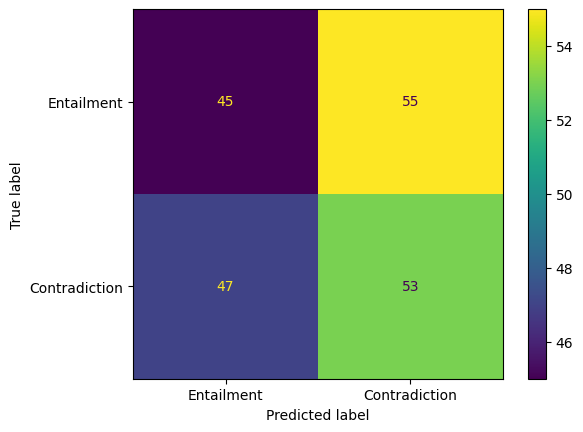

F1:0.509615
precision_score:0.490741
recall_score:0.530000


In [11]:
gold = dev
results = Results
uuid_list = list(results.keys())

results_pred = []
gold_labels = []
for i in range(len(uuid_list)):
    if results[uuid_list[i]]["Prediction"] == "Entailment":
        results_pred.append(1)
    else:
        results_pred.append(0)
    if gold[uuid_list[i]]["Label"] == "Entailment":
        gold_labels.append(1)
    else:
        gold_labels.append(0)

f_score = f1_score(gold_labels,results_pred)
p_score = precision_score(gold_labels,results_pred)
r_score = recall_score(gold_labels,results_pred)


confusion_matrix = metrics.confusion_matrix(gold_labels, results_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Entailment", "Contradiction"])

cm_display.plot()
plt.show()

    
print('F1:{:f}'.format(f_score))
print('precision_score:{:f}'.format(p_score))
print('recall_score:{:f}'.format(r_score))

### now lets define a neural network model and use the bert embedded featurs as input to classify the output of labels

## Dataset Structure Documentation

### Introduction:
This documentation outlines the structure of the dataset used for training and evaluating text classification models. The dataset comprises three columns, each containing specific information essential for classification tasks.

### Dataset Structure:
Due to using Siamese Neural Networks I have made a pairwise input-data structure
The dataset consists of three columns, each serving a distinct purpose:

Primary_Statement Embeddings: This column contains pairs of embedded vectors representing the primary sections of statement pairs. Each row represents a pair of embedded vectors corresponding to the primary sections of statements.
Secondary_Statement Embeddings (Optional): If applicable, this column contains pairs of embedded vectors representing the secondary sections of statement pairs. Similar to the primary section, each row represents a pair of embedded vectors for the secondary sections.
Labels: This column contains the ground truth labels for each statement pair, indicating the correct classification or category assignment. Each label corresponds to a statement pair and is used for training and evaluating classification models.
Column Descriptions:


In [1]:
import os
from utils import prepare_training_dataset
import json
import pandas as pd
import logging

# Load Distilbert Tokenizer and Model
# from transformers import AutoTokenizer, AutoModel
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# model = AutoModel.from_pretrained("distilbert-base-uncased")


# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)



# Example usage
train_path = "training_data/train.json"
ct_json_dir = "training_data/CT json"
training_dataset_df = prepare_training_dataset(train_path, ct_json_dir)


INFO:utils:Processing 34/1700 (2.00%) iterations
INFO:utils:Processing 68/1700 (4.00%) iterations
INFO:utils:Processing 102/1700 (6.00%) iterations
INFO:utils:Processing 136/1700 (8.00%) iterations
INFO:utils:Processing 170/1700 (10.00%) iterations
INFO:utils:Processing 204/1700 (12.00%) iterations
INFO:utils:Processing 272/1700 (16.00%) iterations
INFO:utils:Processing 306/1700 (18.00%) iterations
INFO:utils:Processing 340/1700 (20.00%) iterations
INFO:utils:Processing 374/1700 (22.00%) iterations
INFO:utils:Processing 408/1700 (24.00%) iterations
INFO:utils:Processing 442/1700 (26.00%) iterations
INFO:utils:Processing 510/1700 (30.00%) iterations
INFO:utils:Processing 544/1700 (32.00%) iterations
INFO:utils:Processing 578/1700 (34.00%) iterations
INFO:utils:Processing 612/1700 (36.00%) iterations
INFO:utils:Processing 646/1700 (38.00%) iterations
INFO:utils:Processing 680/1700 (40.00%) iterations
INFO:utils:Processing 714/1700 (42.00%) iterations
INFO:utils:Processing 748/1700 (44.00

In [11]:
# training_dataset_df.to_pickle('training_data/train_dataset.pkl') 

In [12]:
training_dataset_df = pd.read_pickle('training_data/train_dataset.pkl')
training_dataset_df

,Primary_Statement,Secondary_Statement,Label
0,"([[tensor(-0.3614), tensor(0.0419), tensor(0.0...","([[tensor(-0.3614), tensor(0.0419), tensor(0.0...",Contradiction
1,"([[tensor(-0.2886), tensor(-0.0748), tensor(0....",None,Contradiction
2,"([[tensor(-0.3046), tensor(-0.1969), tensor(-0...","([[tensor(-0.3046), tensor(-0.1969), tensor(-0...",Entailment
3,"([[tensor(-0.3505), tensor(-0.3092), tensor(-0...",None,Contradiction
4,"([[tensor(-0.4201), tensor(-0.1263), tensor(-0...","([[tensor(-0.4201), tensor(-0.1263), tensor(-0...",Contradiction
...,...,...,...
1695,"([[tensor(-0.3378), tensor(-0.1518), tensor(-0...","([[tensor(-0.3378), tensor(-0.1518), tensor(-0...",Entailment
1696,"([[tensor(-0.3445), tensor(-0.2399), tensor(-0...",None,Contradiction
1697,"([[tensor(-0.2506), tensor(-0.0957), tensor(-0...",None,Entailment
1698,"([[tensor(-0.3395), tensor(-0.0481), tensor(0....",None,Entailment


## Siamese Networks: Overview and Application in Text Classification

### Introduction:
Siamese networks are a class of neural networks designed to compare and analyze similarity between pairs of inputs. These networks learn to generate embeddings for input data in such a way that similar inputs are mapped closer together in the embedding space. In this documentation, we provide a brief explanation of Siamese networks and discuss their application in text classification tasks.

### Siamese Networks:

Siamese networks consist of two identical subnetworks (twins) that share the same architecture and parameters.
Each subnetwork takes an input (or a pair of inputs) and generates a corresponding embedding vector.
The embeddings produced by the twin subnetworks are then compared to measure the similarity or dissimilarity between the inputs.
Application in Text Classification:

they can be applied to text classification tasks, including similarity detection, paraphrase identification, and authorship attribution.
In text classification, Siamese networks learn to encode the semantic information of textual inputs into embedding vectors.
By training the Siamese network on pairs of text inputs and their corresponding labels (e.g., similar or dissimilar), the network learns to differentiate between similar and dissimilar text pairs.
During inference, the trained Siamese network can be used to compare new pairs of text inputs and predict their similarity or classification.
Advantages of Siamese Networks:

Siamese networks are capable of learning complex nonlinear relationships between inputs, making them suitable for tasks involving subtle semantic differences.
They can effectively handle cases where labeled training data is limited, as they learn to compare inputs based on their inherent similarity rather than relying solely on labeled examples.
Siamese networks offer flexibility in architecture and can be adapted to various types of input data and classification tasks.
### Conclusion:
Siamese networks provide a powerful framework for text classification tasks by learning to compare and analyze similarity between pairs of text inputs. Their ability to generate meaningful embeddings and distinguish between similar and dissimilar inputs makes them valuable tools for a wide range of natural language processing applications.

In [14]:
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from models import SiameseNetwork, MyDataset

# # Define your Siamese network architecture
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()
#         # Define the layers for each branch (embeddings1, embeddings2, embeddings3)
#         self.fc1 = nn.Linear(768, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 128)

#     def forward(self, emb1, emb2, emb3=None):
#         # Implement the forward pass of your Siamese network
#         # Combine the outputs from three branches and pass through additional layers if needed
#         out1 = self.fc3(torch.relu(self.fc2(torch.relu(self.fc1(emb1)))))
#         out2 = self.fc3(torch.relu(self.fc2(torch.relu(self.fc1(emb2)))))
        
#         if emb3 is not None:
#             for sample in emb3:
#                 if not torch.all(torch.isnan(sample)):
#                     out3 = self.fc3(torch.relu(self.fc2(torch.relu(self.fc1(emb3)))))
#                     return out1, out2, out3
#             # If none of the samples passed the condition, return only out1 and out2
#         return out1, out2

# class MyDataset(Dataset):
#     def __init__(self, embeddings1, embeddings2, labels, embeddings3=None):
#         self.embeddings1 = embeddings1
#         self.embeddings2 = embeddings2
#         self.embeddings3 = embeddings3
#         self.labels = labels
#         self.embedding_size = 768  # Assuming the size of each embedding tensor is 768

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         emb1 = self.process_embedding(self.embeddings1[idx])
#         emb2 = self.process_embedding(self.embeddings2[idx])
#         emb3 = self.process_embedding(self.embeddings3[idx]) if self.embeddings3 is not None else None
#         label = self.labels[idx]
#         return emb1, emb2, emb3, label

#     def process_embedding(self, embedding):
#         if embedding is None:
#             return torch.full((self.embedding_size,), float('nan'))
#         return embedding



### Loss Function for siamese networks

in case of training a Siamese network, a common choice for the loss function is the contrastive loss. This loss function encourages the model to embed similar pairs of inputs (positive pairs) close to each other in the embedding space and dissimilar pairs (negative pairs) far apart.

Here's an overview of how the contrastive loss is computed:

For each pair of samples, calculate the Euclidean distance between their output embeddings.
For positive pairs (samples with the same label), minimize this distance, ensuring that similar samples are close together.
For negative pairs (samples with different labels), maximize this distance, pushing dissimilar samples apart.
Combine the losses from all pairs in the batch.

In [15]:
import torch.nn.functional as F
def contrastive_loss(output1, output2, label, margin=1.0):
    distance = F.pairwise_distance(output1, output2)
    loss = torch.mean((1 - label) * torch.pow(distance, 2) +
                      label * torch.pow(torch.clamp(margin - distance, min=0.0), 2))
    return loss


In [16]:
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(training_dataset_df["Label"])

In [20]:
if training_dataset_df['Secondary_Statement'][10] is not None:
    print("AOSIJD")

In [17]:
type(training_dataset_df['Primary_Statement'][1])

tuple

In [19]:
from sklearn.preprocessing import LabelEncoder
import torch.nn.init as init
from torch.utils.data.dataloader import default_collate
import logging

# Configure logging
logging.basicConfig(filename='training.log', level=logging.INFO, format='%(asctime)s - %(message)s')


# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(training_dataset_df["Label"])

embeddings1 = training_dataset_df['Primary_Statement'].apply(lambda tensor: tensor[0][0]).tolist()
embeddings2 = training_dataset_df['Primary_Statement'].apply(lambda tensor: tensor[1][0]).tolist()
embeddings3 = training_dataset_df['Secondary_Statement'].apply(lambda tensor: tensor[1][0] if tensor is not None else None).tolist()
labels = encoded_labels.tolist()


# Define your loss function
criterion = torch.nn.CrossEntropyLoss()
# Define your optimizer
model = SiameseNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


# Initialize model parameters with He initialization
for name, param in model.named_parameters():
    if 'weight' in name:
        init.kaiming_normal_(param.data, mode='fan_in', nonlinearity='relu')
    elif 'bias' in name:
        init.constant_(param.data, 0.0)  # Initialize biases to zeros


def my_collate_fn(batch):
    # Check if the third element of any data in the batch is None
    has_none = any(data[2] is None for data in batch)

    # If any data in the batch has the third element as None
    if has_none:
        # Filter out None values from the batch while keeping other elements intact
        filtered_batch = [(data[0], data[1], data[3]) if data[2] is None else data for data in batch]
        return default_collate(filtered_batch)
    else:
        # Use the default collate function for the entire batch
        return default_collate(batch)


# Flag variables to track if statements have been executed
if_block_executed = False
else_block_executed = False

# # Prepare your data and dataloaders
# train_dataset = MyDataset(embeddings1, embeddings2, embeddings3, labels)
train_dataset = MyDataset(embeddings1, embeddings2, labels)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=my_collate_fn)

# Training loop
num_epochs = 10
total_iterations = len(train_dataloader) * num_epochs
current_iteration = 0

for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize running loss for the epoch
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        if len(batch)==3:
            # In case we want to use only the first statements
            print("using only the first statements")
            if_block_executed = True
            emb1_valid, emb2_valid, labels_valid = batch
        
            # Forward pass and compute loss
            out1, out2 = model(emb1_valid, emb2_valid)
            loss = contrastive_loss(out1, out2, labels_valid)
            
        elif len(batch) > 3 and not else_block_executed:  
            # in case we want to use the emb3 ( seccond statements )
            print("using the first and second statements if there is")
            else_block_executed = True
            # Filter out samples where emb3 contains NaN values
            valid_samples = [(e1, e2, e3, lbl) for e1, e2, e3, lbl in zip(emb1, emb2, emb3, labels) if not torch.isnan(torch.tensor(e3)).any()]
        
            if not valid_samples:
                continue  # Skip batch if all samples have NaN values in emb3
            
            # Unpack valid samples
            emb1_valid, emb2_valid, emb3_valid, labels_valid = zip(*valid_samples)
            
            # Convert to tensors
            emb1_valid = torch.stack(emb1_valid)
            emb2_valid = torch.stack(emb2_valid)
            emb3_valid = torch.stack(emb3_valid)
            labels_valid = torch.stack(labels_valid)
            
            # Forward pass and compute loss
            if emb3 is not None:
                out1, out2, out3 = model(emb1_valid, emb2_valid, emb3_valid)
                loss = (contrastive_loss(out1, out2, labels_valid) +
                        contrastive_loss(out2, out3, labels_valid))
            else:
                out1, out2 = model(emb1_valid, emb2_valid)
                loss = contrastive_loss(out1, out2, labels_valid)

                
        else:
            # using the batch
            continue  # Skip processing the batch if both blocks have been executed

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        
        # Print and log the loss
        running_loss += loss.item()
        current_iteration += 1
        if current_iteration % 5 == 0:  # Print and log every 100 iterations  
            avg_loss = running_loss / 100
            print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{current_iteration}/{total_iterations}], Loss: {avg_loss:.4f}')
            if logging.getLogger().getEffectiveLevel() == logging.INFO:
                logging.info(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{current_iteration}/{total_iterations}], Loss: {avg_loss:.4f}')
            running_loss = 0.0  # Reset running loss

print('Finished Training')


INFO:root:Epoch [1/10], Iteration [5/270], Loss: 0.0946
INFO:root:Epoch [1/10], Iteration [10/270], Loss: 0.0383


using only the first statements
1
using only the first statements
2
using only the first statements
3
using only the first statements
4
using only the first statements
5
Epoch [1/10], Iteration [5/270], Loss: 0.0946
using only the first statements
6
using only the first statements
7
using only the first statements
8
using only the first statements
9
using only the first statements
10
Epoch [1/10], Iteration [10/270], Loss: 0.0383


INFO:root:Epoch [1/10], Iteration [15/270], Loss: 0.0219
INFO:root:Epoch [1/10], Iteration [20/270], Loss: 0.0192


using only the first statements
11
using only the first statements
12
using only the first statements
13
using only the first statements
14
using only the first statements
15
Epoch [1/10], Iteration [15/270], Loss: 0.0219
using only the first statements
16
using only the first statements
17
using only the first statements
18
using only the first statements
19
using only the first statements
20
Epoch [1/10], Iteration [20/270], Loss: 0.0192
using only the first statements
21
using only the first statements
22
using only the first statements
23
using only the first statements


INFO:root:Epoch [1/10], Iteration [25/270], Loss: 0.0170
INFO:root:Epoch [2/10], Iteration [30/270], Loss: 0.0085
INFO:root:Epoch [2/10], Iteration [35/270], Loss: 0.0146
INFO:root:Epoch [2/10], Iteration [40/270], Loss: 0.0132


24
using only the first statements
25
Epoch [1/10], Iteration [25/270], Loss: 0.0170
using only the first statements
26
using only the first statements
27
using only the first statements
28
using only the first statements
29
using only the first statements
30
Epoch [2/10], Iteration [30/270], Loss: 0.0085
using only the first statements
31
using only the first statements
32
using only the first statements
33
using only the first statements
34
using only the first statements
35
Epoch [2/10], Iteration [35/270], Loss: 0.0146
using only the first statements
36
using only the first statements
37
using only the first statements
38
using only the first statements
39
using only the first statements
40
Epoch [2/10], Iteration [40/270], Loss: 0.0132


INFO:root:Epoch [2/10], Iteration [45/270], Loss: 0.0143
INFO:root:Epoch [2/10], Iteration [50/270], Loss: 0.0139
INFO:root:Epoch [3/10], Iteration [55/270], Loss: 0.0024


using only the first statements
41
using only the first statements
42
using only the first statements
43
using only the first statements
44
using only the first statements
45
Epoch [2/10], Iteration [45/270], Loss: 0.0143
using only the first statements
46
using only the first statements
47
using only the first statements
48
using only the first statements
49
using only the first statements
50
Epoch [2/10], Iteration [50/270], Loss: 0.0139
using only the first statements
51
using only the first statements
52
using only the first statements
53
using only the first statements
54
using only the first statements
55
Epoch [3/10], Iteration [55/270], Loss: 0.0024
using only the first statements
56
using only the first statements
57
using only the first statements
58
using only the first statements
59
using only the first statements


INFO:root:Epoch [3/10], Iteration [60/270], Loss: 0.0135
INFO:root:Epoch [3/10], Iteration [65/270], Loss: 0.0125
INFO:root:Epoch [3/10], Iteration [70/270], Loss: 0.0130
INFO:root:Epoch [3/10], Iteration [75/270], Loss: 0.0131


60
Epoch [3/10], Iteration [60/270], Loss: 0.0135
using only the first statements
61
using only the first statements
62
using only the first statements
63
using only the first statements
64
using only the first statements
65
Epoch [3/10], Iteration [65/270], Loss: 0.0125
using only the first statements
66
using only the first statements
67
using only the first statements
68
using only the first statements
69
using only the first statements
70
Epoch [3/10], Iteration [70/270], Loss: 0.0130
using only the first statements
71
using only the first statements
72
using only the first statements
73
using only the first statements
74
using only the first statements
75
Epoch [3/10], Iteration [75/270], Loss: 0.0131
using only the first statements
76
using only the first statements
77
using only the first statements
78
using only the first statements


INFO:root:Epoch [3/10], Iteration [80/270], Loss: 0.0137
INFO:root:Epoch [4/10], Iteration [85/270], Loss: 0.0098
INFO:root:Epoch [4/10], Iteration [90/270], Loss: 0.0127
INFO:root:Epoch [4/10], Iteration [95/270], Loss: 0.0123


79
using only the first statements
80
Epoch [3/10], Iteration [80/270], Loss: 0.0137
using only the first statements
81
using only the first statements
82
using only the first statements
83
using only the first statements
84
using only the first statements
85
Epoch [4/10], Iteration [85/270], Loss: 0.0098
using only the first statements
86
using only the first statements
87
using only the first statements
88
using only the first statements
89
using only the first statements
90
Epoch [4/10], Iteration [90/270], Loss: 0.0127
using only the first statements
91
using only the first statements
92
using only the first statements
93
using only the first statements
94
using only the first statements
95
Epoch [4/10], Iteration [95/270], Loss: 0.0123
using only the first statements
96
using only the first statements
97
using only the first statements
98
using only the first statements


INFO:root:Epoch [4/10], Iteration [100/270], Loss: 0.0128
INFO:root:Epoch [4/10], Iteration [105/270], Loss: 0.0128
INFO:root:Epoch [5/10], Iteration [110/270], Loss: 0.0050
INFO:root:Epoch [5/10], Iteration [115/270], Loss: 0.0122


99
using only the first statements
100
Epoch [4/10], Iteration [100/270], Loss: 0.0128
using only the first statements
101
using only the first statements
102
using only the first statements
103
using only the first statements
104
using only the first statements
105
Epoch [4/10], Iteration [105/270], Loss: 0.0128
using only the first statements
106
using only the first statements
107
using only the first statements
108
using only the first statements
109
using only the first statements
110
Epoch [5/10], Iteration [110/270], Loss: 0.0050
using only the first statements
111
using only the first statements
112
using only the first statements
113
using only the first statements
114
using only the first statements
115
Epoch [5/10], Iteration [115/270], Loss: 0.0122
using only the first statements
116
using only the first statements
117
using only the first statements
118
using only the first statements


INFO:root:Epoch [5/10], Iteration [120/270], Loss: 0.0128
INFO:root:Epoch [5/10], Iteration [125/270], Loss: 0.0123
INFO:root:Epoch [5/10], Iteration [130/270], Loss: 0.0130
INFO:root:Epoch [5/10], Iteration [135/270], Loss: 0.0126
INFO:root:Epoch [6/10], Iteration [140/270], Loss: 0.0121


119
using only the first statements
120
Epoch [5/10], Iteration [120/270], Loss: 0.0128
using only the first statements
121
using only the first statements
122
using only the first statements
123
using only the first statements
124
using only the first statements
125
Epoch [5/10], Iteration [125/270], Loss: 0.0123
using only the first statements
126
using only the first statements
127
using only the first statements
128
using only the first statements
129
using only the first statements
130
Epoch [5/10], Iteration [130/270], Loss: 0.0130
using only the first statements
131
using only the first statements
132
using only the first statements
133
using only the first statements
134
using only the first statements
135
Epoch [5/10], Iteration [135/270], Loss: 0.0126
using only the first statements
136
using only the first statements
137
using only the first statements
138
using only the first statements
139
using only the first statements
140
Epoch [6/10], Iteration [140/270], Loss: 0.0121


INFO:root:Epoch [6/10], Iteration [145/270], Loss: 0.0122
INFO:root:Epoch [6/10], Iteration [150/270], Loss: 0.0124
INFO:root:Epoch [6/10], Iteration [155/270], Loss: 0.0122


using only the first statements
141
using only the first statements
142
using only the first statements
143
using only the first statements
144
using only the first statements
145
Epoch [6/10], Iteration [145/270], Loss: 0.0122
using only the first statements
146
using only the first statements
147
using only the first statements
148
using only the first statements
149
using only the first statements
150
Epoch [6/10], Iteration [150/270], Loss: 0.0124
using only the first statements
151
using only the first statements
152
using only the first statements
153
using only the first statements
154
using only the first statements
155
Epoch [6/10], Iteration [155/270], Loss: 0.0122
using only the first statements
156
using only the first statements
157
using only the first statements
158
using only the first statements
159


INFO:root:Epoch [6/10], Iteration [160/270], Loss: 0.0127
INFO:root:Epoch [7/10], Iteration [165/270], Loss: 0.0070
INFO:root:Epoch [7/10], Iteration [170/270], Loss: 0.0120
INFO:root:Epoch [7/10], Iteration [175/270], Loss: 0.0120


using only the first statements
160
Epoch [6/10], Iteration [160/270], Loss: 0.0127
using only the first statements
161
using only the first statements
162
using only the first statements
163
using only the first statements
164
using only the first statements
165
Epoch [7/10], Iteration [165/270], Loss: 0.0070
using only the first statements
166
using only the first statements
167
using only the first statements
168
using only the first statements
169
using only the first statements
170
Epoch [7/10], Iteration [170/270], Loss: 0.0120
using only the first statements
171
using only the first statements
172
using only the first statements
173
using only the first statements
174
using only the first statements
175
Epoch [7/10], Iteration [175/270], Loss: 0.0120


INFO:root:Epoch [7/10], Iteration [180/270], Loss: 0.0124
INFO:root:Epoch [7/10], Iteration [185/270], Loss: 0.0122
INFO:root:Epoch [8/10], Iteration [190/270], Loss: 0.0022


using only the first statements
176
using only the first statements
177
using only the first statements
178
using only the first statements
179
using only the first statements
180
Epoch [7/10], Iteration [180/270], Loss: 0.0124
using only the first statements
181
using only the first statements
182
using only the first statements
183
using only the first statements
184
using only the first statements
185
Epoch [7/10], Iteration [185/270], Loss: 0.0122
using only the first statements
186
using only the first statements
187
using only the first statements
188
using only the first statements
189
using only the first statements
190
Epoch [8/10], Iteration [190/270], Loss: 0.0022
using only the first statements
191
using only the first statements
192
using only the first statements
193
using only the first statements
194
using only the first statements


INFO:root:Epoch [8/10], Iteration [195/270], Loss: 0.0116
INFO:root:Epoch [8/10], Iteration [200/270], Loss: 0.0119
INFO:root:Epoch [8/10], Iteration [205/270], Loss: 0.0119
INFO:root:Epoch [8/10], Iteration [210/270], Loss: 0.0120


195
Epoch [8/10], Iteration [195/270], Loss: 0.0116
using only the first statements
196
using only the first statements
197
using only the first statements
198
using only the first statements
199
using only the first statements
200
Epoch [8/10], Iteration [200/270], Loss: 0.0119
using only the first statements
201
using only the first statements
202
using only the first statements
203
using only the first statements
204
using only the first statements
205
Epoch [8/10], Iteration [205/270], Loss: 0.0119
using only the first statements
206
using only the first statements
207
using only the first statements
208
using only the first statements
209
using only the first statements
210
Epoch [8/10], Iteration [210/270], Loss: 0.0120
using only the first statements
211
using only the first statements
212
using only the first statements
213
using only the first statements


INFO:root:Epoch [8/10], Iteration [215/270], Loss: 0.0121
INFO:root:Epoch [9/10], Iteration [220/270], Loss: 0.0094
INFO:root:Epoch [9/10], Iteration [225/270], Loss: 0.0116
INFO:root:Epoch [9/10], Iteration [230/270], Loss: 0.0114


214
using only the first statements
215
Epoch [8/10], Iteration [215/270], Loss: 0.0121
using only the first statements
216
using only the first statements
217
using only the first statements
218
using only the first statements
219
using only the first statements
220
Epoch [9/10], Iteration [220/270], Loss: 0.0094
using only the first statements
221
using only the first statements
222
using only the first statements
223
using only the first statements
224
using only the first statements
225
Epoch [9/10], Iteration [225/270], Loss: 0.0116
using only the first statements
226
using only the first statements
227
using only the first statements
228
using only the first statements
229
using only the first statements
230
Epoch [9/10], Iteration [230/270], Loss: 0.0114
using only the first statements
231
using only the first statements
232
using only the first statements
233
using only the first statements


INFO:root:Epoch [9/10], Iteration [235/270], Loss: 0.0121
INFO:root:Epoch [9/10], Iteration [240/270], Loss: 0.0117
INFO:root:Epoch [10/10], Iteration [245/270], Loss: 0.0046
INFO:root:Epoch [10/10], Iteration [250/270], Loss: 0.0114


234
using only the first statements
235
Epoch [9/10], Iteration [235/270], Loss: 0.0121
using only the first statements
236
using only the first statements
237
using only the first statements
238
using only the first statements
239
using only the first statements
240
Epoch [9/10], Iteration [240/270], Loss: 0.0117
using only the first statements
241
using only the first statements
242
using only the first statements
243
using only the first statements
244
using only the first statements
245
Epoch [10/10], Iteration [245/270], Loss: 0.0046
using only the first statements
246
using only the first statements
247
using only the first statements
248
using only the first statements
249
using only the first statements
250
Epoch [10/10], Iteration [250/270], Loss: 0.0114


INFO:root:Epoch [10/10], Iteration [255/270], Loss: 0.0129
INFO:root:Epoch [10/10], Iteration [260/270], Loss: 0.0119


using only the first statements
251
using only the first statements
252
using only the first statements
253
using only the first statements
254
using only the first statements
255
Epoch [10/10], Iteration [255/270], Loss: 0.0129
using only the first statements
256
using only the first statements
257
using only the first statements
258
using only the first statements
259
using only the first statements
260
Epoch [10/10], Iteration [260/270], Loss: 0.0119
using only the first statements
261
using only the first statements
262
using only the first statements
263
using only the first statements
264
using only the first statements


INFO:root:Epoch [10/10], Iteration [265/270], Loss: 0.0117
INFO:root:Epoch [10/10], Iteration [270/270], Loss: 0.0115


265
Epoch [10/10], Iteration [265/270], Loss: 0.0117
using only the first statements
266
using only the first statements
267
using only the first statements
268
using only the first statements
269
using only the first statements
270
Epoch [10/10], Iteration [270/270], Loss: 0.0115
Finished Training


In [20]:
# Assuming you have a separate validation dataset called val_dataset
# Example usage
# Load Distilbert Tokenizer and Model
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

train_path = "training_data/dev.json"
ct_json_dir = "training_data/CT json"
dev_dataset_df = prepare_training_dataset(train_path, ct_json_dir)


INFO:utils:Processing 4/200 (2.00%) iterations
INFO:utils:Processing 8/200 (4.00%) iterations
INFO:utils:Processing 12/200 (6.00%) iterations
INFO:utils:Processing 16/200 (8.00%) iterations
INFO:utils:Processing 20/200 (10.00%) iterations
INFO:utils:Processing 24/200 (12.00%) iterations
INFO:utils:Processing 32/200 (16.00%) iterations
INFO:utils:Processing 36/200 (18.00%) iterations
INFO:utils:Processing 40/200 (20.00%) iterations
INFO:utils:Processing 44/200 (22.00%) iterations
INFO:utils:Processing 48/200 (24.00%) iterations
INFO:utils:Processing 52/200 (26.00%) iterations
INFO:utils:Processing 60/200 (30.00%) iterations
INFO:utils:Processing 64/200 (32.00%) iterations
INFO:utils:Processing 68/200 (34.00%) iterations
INFO:utils:Processing 72/200 (36.00%) iterations
INFO:utils:Processing 76/200 (38.00%) iterations
INFO:utils:Processing 80/200 (40.00%) iterations
INFO:utils:Processing 84/200 (42.00%) iterations
INFO:utils:Processing 88/200 (44.00%) iterations
INFO:utils:Processing 92/2

In [21]:
if embeddings3[3] is None:
    print("yolo")

yolo


In [25]:
# Example tensor with floating point values
float_tensor = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# Suppose you want to use this tensor as indices for torch.embedding()
# Convert the tensor to torch.LongTensor
indices = float_tensor.long()

# Now you can safely use the indices tensor with torch.embedding()
# For example, assume weight is another tensor
weight = torch.randn(10, 5)  # Example weight tensor
embedding = torch.embedding(weight, indices)

print(embedding)

tensor([[-0.9214, -0.7635, -1.0523,  1.0848,  1.1425],
        [-0.3863,  2.5177,  0.6401, -1.1675,  0.3766],
        [-0.0884, -1.8983,  1.7602,  0.0038, -0.0588],
        [-0.9761,  0.4840, -0.4445,  0.1491,  1.2465],
        [-0.1541, -0.3167, -1.2651,  1.0147, -0.9140]])


In [26]:
model = SiameseNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [27]:
import torch.nn.functional as F

label_encoder = LabelEncoder()


# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(dev_dataset_df["Label"])

embeddings1 = dev_dataset_df['Primary_Statement'].apply(lambda tensor: tensor[0][0]).tolist()
embeddings2 = dev_dataset_df['Primary_Statement'].apply(lambda tensor: tensor[1][0]).tolist()
embeddings3 = dev_dataset_df['Secondary_Statement'].apply(lambda tensor: tensor[1][0] if tensor is not None else None).tolist()
labels = encoded_labels.tolist()

# Define DataLoader for validation dataset
# val_dataset = MyDataset(embeddings1, embeddings2, embeddings3, labels)
val_dataset = MyDataset(embeddings1, embeddings2, labels)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=my_collate_fn)  # No need to shuffle for validation
threshold=0.9

flag1 = False
flag2 = False
# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in val_dataloader:
        optimizer.zero_grad()

        if len(batch) == 3:
            # In case we want to use only the first statements
            print("using only the first statements")
            flag1 = True
            emb1_valid, emb2_valid, labels_valid = batch
            # Forward pass and compute predictions
            out1, out2 = model(emb1_valid, emb2_valid)
            # Calculate cosine similarity
            similarity = F.cosine_similarity(out1, out2, dim=1)
            predictions = (similarity > threshold).int()

        elif len(batch) > 3 and not flag2:
            # in case we want to use the emb3 ( second statements )
            print("using the first and second statements if there is")
            flag2 = True
            # Filter out samples where emb3 contains NaN values
            valid_samples = [(e1, e2, e3, lbl) for e1, e2, e3, lbl in zip(batch[0], batch[1], batch[2], batch[3]) if not torch.isnan(e3.clone().detach()).any()]

            if not valid_samples:
                continue  # Skip batch if all samples have NaN values in emb3

            # Unpack valid samples
            emb1_valid, emb2_valid, emb3_valid, labels_valid = zip(*valid_samples)

            # Convert to tensors
            emb1_valid = torch.stack(emb1_valid)
            emb2_valid = torch.stack(emb2_valid)
            emb3_valid = torch.stack(emb3_valid)
            labels_valid = torch.stack(labels_valid)

            if emb3_valid is not None:
                out1, out2, out3 = model(emb1_valid, emb2_valid, emb3_valid)
                similarity = F.cosine_similarity(out1, out2, dim=1)
                predictions = (similarity > threshold).int()
            else:
                out1, out2 = model(emb1_valid, emb2_valid)
                similarity = F.cosine_similarity(out1, out2, dim=1)
                predictions = (similarity > threshold).int()

        else:
            continue  # Skip processing the batch if both blocks have been executed

        total += labels_valid.size(0)
        correct += (predictions == labels_valid).sum().item()

accuracy = correct / total
print("Accuracy:", accuracy)



using only the first statements
64
using only the first statements
64
using only the first statements
64
using only the first statements
8
Accuracy: 0.5


In [28]:
import torch.nn.functional as F

def load_data(dev_dataset_df, batch_size=64, shuffle=False):
    # Fit and transform the labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(dev_dataset_df["Label"])

    embeddings1 = dev_dataset_df['Primary_Statement'].apply(lambda tensor: tensor[0][0]).tolist()
    embeddings2 = dev_dataset_df['Primary_Statement'].apply(lambda tensor: tensor[1][0]).tolist()
    embeddings3 = dev_dataset_df['Secondary_Statement'].apply(lambda tensor: tensor[1][0] if tensor is not None else None).tolist()
    labels = encoded_labels.tolist()

    # Define DataLoader for validation dataset
    val_dataset = MyDataset(embeddings1, embeddings2, labels)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=my_collate_fn)

    return val_dataloader, label_encoder

from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, val_dataloader, threshold):
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    labels_list = []
    with torch.no_grad():
        for batch in val_dataloader:
            if len(batch) == 3:  # Using only the first statements
                emb1_valid, emb2_valid, labels_valid = batch
                out1, out2 = model(emb1_valid, emb2_valid)
                similarity = F.cosine_similarity(out1, out2, dim=1)
                predictions = (similarity > threshold).int()

            elif len(batch) > 3:  # Using both first and second statements
                valid_samples = [(e1, e2, e3, lbl) for e1, e2, e3, lbl in zip(batch[0], batch[1], batch[2], batch[3]) if not torch.isnan(e3.clone().detach()).any()]
                if not valid_samples:
                    continue
                emb1_valid, emb2_valid, emb3_valid, labels_valid = zip(*valid_samples)
                emb1_valid = torch.stack(emb1_valid)
                emb2_valid = torch.stack(emb2_valid)
                emb3_valid = torch.stack(emb3_valid)
                labels_valid = torch.stack(labels_valid)
                if emb3_valid is not None:
                    out1, out2, out3 = model(emb1_valid, emb2_valid, emb3_valid)
                    similarity = F.cosine_similarity(out1, out3, dim=1)
                    predictions = (similarity > threshold).int()
                else:
                    out1, out2 = model(emb1_valid, emb2_valid)
                    similarity = F.cosine_similarity(out1, out2, dim=1)
                    predictions = (similarity > threshold).int()

            else:
                continue

            total += labels_valid.size(0)
            correct += (predictions == labels_valid).sum().item()
            
            # Collect predictions and labels for F1 score calculation
            predictions_list.extend(predictions.tolist())
            labels_list.extend(labels_valid.tolist())

    accuracy = correct / total
    precision = precision_score(labels_list, predictions_list)
    confusion_matrix = metrics.confusion_matrix(labels_list, predictions_list)
    recall = recall_score(labels_list, predictions_list)
    f1 = f1_score(labels_list, predictions_list)

    return accuracy, precision, recall, f1, confusion_matrix


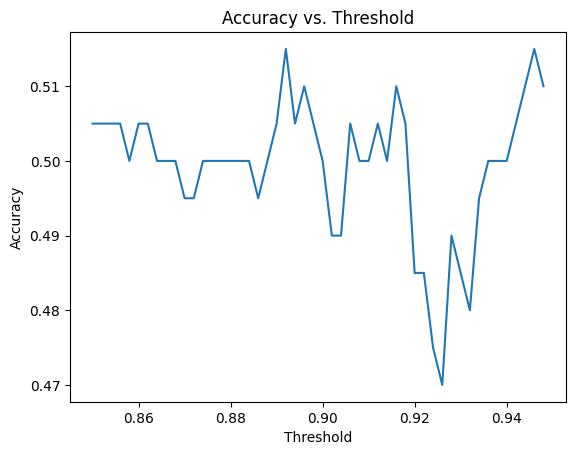

Best Threshold: 0.892
Best f1 score:  0.6666666666666666
Best Accuracy: 0.515000


In [32]:
import torch.nn.functional as F
from sklearn import metrics
import numpy as np

def optimize_threshold(model, val_dataloader, threshold_values):
    accuracies = [] # Store accuracies as float numbers
    f1_scores = []
    for threshold in threshold_values:
        accuracy, precision, recall, f1, _ = evaluate_model(model, val_dataloader, threshold)
        accuracies.append(accuracy)
        f1_scores.append(f1)

    best_accuracy = max(accuracies)
    best_f1 = max(f1_scores)
    best_threshold = threshold_values[accuracies.index(best_accuracy)]
    
    plt.plot(threshold_values, accuracies)
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')
    plt.show()
    
    return best_accuracy, best_f1, best_threshold

# Load data
val_dataloader, label_encoder = load_data(dev_dataset_df)


# Define the number of thresholds you want
num_thresholds = 50

# Generate thresholds between 0.8 and 0.95
threshold_values = [0.85+(i*0.002) for i in range(num_thresholds)]

# Optimize threshold
best_accuracy, f1, best_threshold= optimize_threshold(model, val_dataloader, threshold_values)

print("Best Threshold:", best_threshold)
print("Best f1 score: ", f1)
print("Best Accuracy:", format(best_accuracy, '.6f'))  # Print accuracy with exact float number


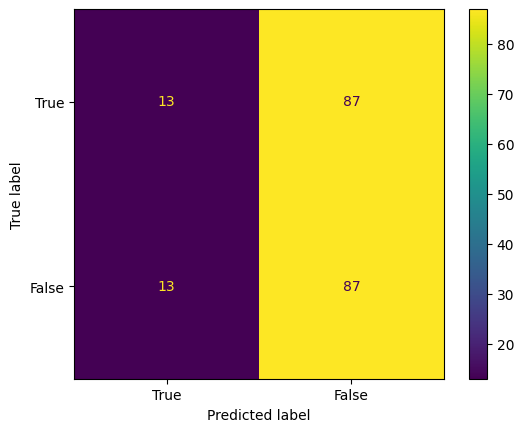

In [34]:
_, _, _, _, confusion_matrix = evaluate_model(model, val_dataloader, threshold)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True, False])

cm_display.plot()
plt.show()